In [1]:
import os
import re
import sys
import glob
import pickle
from collections import OrderedDict

import numpy as np
from scipy.optimize import curve_fit
import matplotlib
from matplotlib import rcParams
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow import keras

if '..' not in sys.path:
    sys.path.append('..')
from dlml.utils import collect_experiments
from dlml.data import read_area_values, load_data_slide
from dlml.nn import predict

#### Find the best experiment given a set of tags

In [2]:
area_ID = 1
area_measure = 'momentum'
stoch_load_bus_IDs = []
rec_bus_IDs = [3, 14, 16, 17]
H_G1, D, DZA = None, None, None # 500, 2, 0
additional_tags = ['ReLU_none', 'converted_from_PowerFactory', 'all_stoch_loads']

experiments = collect_experiments(area_ID, area_measure=area_measure, D=D, DZA=DZA, \
                                  stoch_load_bus_IDs=stoch_load_bus_IDs, H_G1=H_G1, \
                                  rec_bus_IDs=rec_bus_IDs, additional_tags=additional_tags, \
                                  verbose=True)
experiment_IDs = list(experiments.keys())
experiment_ID = experiment_IDs[np.argmin([expt['val_loss'].min() for expt in experiments.values()])]
MAPE = experiments[experiment_ID]['MAPE']
loss = experiments[experiment_ID]['loss']
val_loss = experiments[experiment_ID]['val_loss']
batch_loss = experiments[experiment_ID]['batch_loss']
tags = experiments[experiment_ID]['tags']
print(f'The best experiment is {experiment_ID[:6]} (val_loss = {val_loss.min():.4f}, MAPE = {MAPE:.4f}%).')

Query: (((((((Tag('IEEE39') & Tag('area_measure_momentum')) & Tag('1D_pipeline')) & Tag('area1')) & Tag('buses_3-14-16-17')) & Tag('ReLU_none')) & Tag('converted_from_PowerFactory')) & Tag('all_stoch_loads'))
[01/11] downloading data for experiment ID 2cfc2da9cec3481a980554db2a827758... done.
  val_loss: 0.0061
      MAPE: 2.675%
      Tags: "1D_pipeline" "all_stoch_loads" "area1" "area_measure_momentum" "buses_3-14-16-17" "converted_from_PowerFactory" "IEEE39" "neural_network" "ReLU_none" "streams_arch_0"
[02/11] downloading data for experiment ID add0ffd6db764f2dbba7ce01b629f546... done.
  val_loss: 0.0057
      MAPE: 2.512%
      Tags: "1D_pipeline" "all_stoch_loads" "area1" "area_measure_momentum" "buses_3-14-16-17" "converted_from_PowerFactory" "IEEE39" "neural_network" "ReLU_none" "streams_arch_0"
[03/11] downloading data for experiment ID ddc4fbe57a694381be832c74c03dbfc7... done.
  val_loss: 0.0418
      MAPE: 18.813%
      Tags: "1D_pipeline" "all_stoch_loads" "area1" "area_mea

In [4]:
experiments_path = '../experiments/neural_network/'
checkpoint_path = experiments_path + experiment_ID + '/checkpoints/'
checkpoint_files = glob.glob(checkpoint_path + '*.h5')
network_parameters = pickle.load(open(experiments_path + experiment_ID \
                                      + '/parameters.pkl', 'rb'))
epochs = [int(os.path.split(file)[-1].split('.')[1].split('-')[0]) for file in checkpoint_files]
best_checkpoint = checkpoint_files[epochs.index(np.argmin(val_loss) + 1)]
model = keras.models.load_model(best_checkpoint, compile=False)
model.compile()
data_dirs = ['..' + os.path.sep +
             os.path.sep.join([d for d in data_dir.split(os.path.sep) if '{}' not in d])
             for data_dir in network_parameters['data_dirs']]
for i in range(len(data_dirs)):
#              f'/H_G1_{H_G1}/stoch_load_bus_' + '-'.join(map(str, stoch_load_bus_IDs))
    if H_G1 is not None:
        data_dirs[i] += f'/H_G1_{H_G1}'
    if stoch_load_bus_IDs is not None and len(stoch_load_bus_IDs) > 0:
        data_dirs[i] += '/stoch_load_bus_' + '-'.join(map(str, stoch_load_bus_IDs))
# we need mean and standard deviation of the training set to normalize the data
x_train_mean = network_parameters['x_train_mean']
x_train_std  = network_parameters['x_train_std']
data_dir = data_dirs[0]
tmp = [re.findall('.*_bus', var_name)[0] for var_name in network_parameters['var_names'] if 'bus' in var_name]
var_names_fmt = OrderedDict({k + '{}': [] for k in tmp})
tmp = [re.findall('.*_line', var_name)[0] for var_name in network_parameters['var_names'] if 'line' in var_name]
for k in tmp:
    var_names_fmt[k + '_{}_{}'] = []
var_names_fmt = list(var_names_fmt.keys())
if len(rec_bus_IDs) == 0:
    rec_bus_IDs = list(np.unique([int(re.findall('\d+', var_name)[0]) \
                                  for var_name in network_parameters['var_names']]))
    rec_bus_list = 'buses_' + '-'.join(map(str, rec_bus_IDs))
if not os.path.isdir(data_dir):
    raise Exception(f'{data_dir}: no such directory')
print(f'Loaded network from {best_checkpoint}.')
print(f'Data directory is {data_dir}.')
print(f'Variable names: {var_names_fmt}')

Loaded network from ../experiments/neural_network/2d43fe81d24f49c4825b863692d3dd38/checkpoints/weights.0037-0.004688.h5.
Data directory is ../data/IEEE39/converted_from_PowerFactory/all_stoch_loads.
Variable names: ['Vd_bus{}', 'Vq_bus{}', 'Id_line_{}_{}', 'Iq_line_{}_{}']


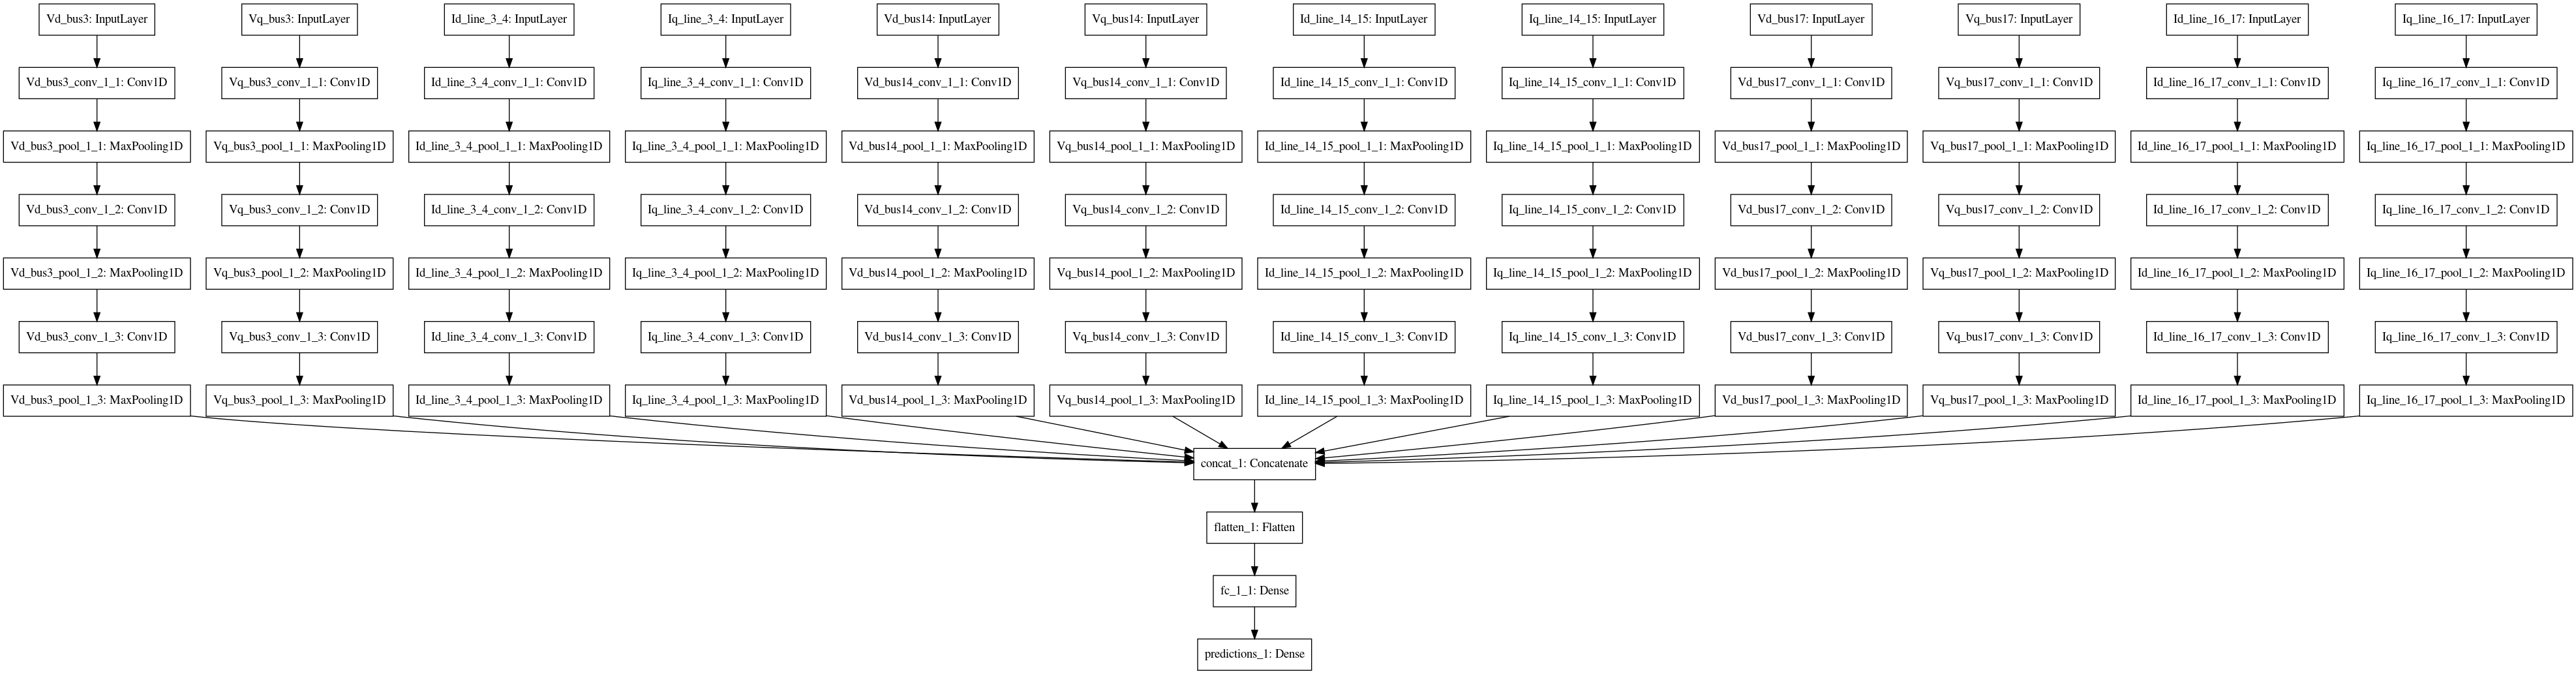

In [5]:
keras.utils.plot_model(model, show_shapes=False, dpi=96)

In [6]:
default_H = OrderedDict([
    ('G01', 5.00), ('G02', 4.33), ('G03', 4.47), ('G04', 3.57), ('G05', 4.33),
    ('G06', 4.35), ('G07', 3.77), ('G08', 3.47), ('G09', 3.45), ('G10', 4.20)
])


generators_areas_map = {
    'default': [
        ['G02', 'G03'],
        ['G04', 'G05', 'G06', 'G07'],
        ['G08', 'G09', 'G10'],
        ['G01']
    ]
}

P_nom = {'G01': 10000e6, 'G02': 700e6, 'G03': 800e6, 'G04':  800e6, 'G05':  300e6,
         'G06':   800e6, 'G07': 700e6, 'G08': 700e6, 'G09': 1000e6, 'G10': 1000e6}


window_dur = 60
window_step = 1

var_names = network_parameters['var_names']
data_mean = {var_name: x_train_mean[k] for k,var_name in enumerate(var_names)}
data_std = {var_name: x_train_std[k] for k,var_name in enumerate(var_names)}

if area_measure == 'inertia':
    measure_units = 's'
elif area_measure == 'energy':
    measure_units = r'GW$\cdot$s'
elif area_measure == 'momentum':
    measure_units = r'GW$\cdot$s$^2$'
    
stoch_load_bus_list = 'stoch_load_bus_' + '-'.join(map(str, stoch_load_bus_IDs))
rec_bus_list = 'buses_' + '-'.join(map(str, rec_bus_IDs))

abbrv = {'inertia': 'H', 'energy': 'E', 'momentum': 'M'}

## Constant measure

In [8]:
H_values = [
    default_H,
    OrderedDict([
        ('G01', 5.00), ('G02', 3.3), ('G03', 3.3), ('G04', 3.57), ('G05', 4.33),
        ('G06', 4.35), ('G07', 3.77), ('G08', 3.47), ('G09', 3.45), ('G10', 4.20)
    ]),
    OrderedDict([
        ('G01', 5.00), ('G02', 5.8), ('G03', 5.8), ('G04', 3.57), ('G05', 4.33),
        ('G06', 4.35), ('G07', 3.77), ('G08', 3.47), ('G09', 3.45), ('G10', 4.2)
    ])
]
N_H = len(H_values)

measure_exact = []

data_normalized = []
measure = []
area_inertia = []

for H in H_values:
    data_file = data_dir + '/ieee39_PF_stoch_loads_compensators_' + \
        '_'.join(map(lambda h: f'{h:.3f}', H.values())) + '.h5'
    _,_,v,_ = read_area_values(data_file, generators_areas_map['default'], P_nom, area_measure)
    _,_,h,_ = read_area_values(data_file, generators_areas_map['default'], P_nom, 'inertia')
    measure_exact.append(v[area_ID - 1])
    area_inertia.append(h[area_ID - 1])

    t, _, data_norm, data_sliding, _ = load_data_slide([data_file],
                                                        var_names,
                                                        data_mean,
                                                        data_std,
                                                        window_dur,
                                                        window_step,
                                                        add_omega_ref = False,
                                                        verbose = True)
    data_normalized.append(data_norm)
    dt = np.diff(t[:2])[0]
    time, HH, _ = predict(model, data_sliding, window_step)
    measure.append(HH)
measure_exact = np.array(measure_exact)
area_inertia = np.array(area_inertia)
measure_predicted = np.array(list(map(np.nanmean, measure)))

Window size: 2400 samples
Window step size: 40 samples
Number of trials: 540
Window size: 2400 samples
Window step size: 40 samples
Number of trials: 540
Window size: 2400 samples
Window step size: 40 samples
Number of trials: 540


In [9]:
area_inertia

array([4.40466667, 3.3       , 5.8       ])

In [10]:
measure_exact

array([0.22023333, 0.165     , 0.29      ])

In [11]:
measure_predicted

array([0.22197989, 0.16885781, 0.28850578])

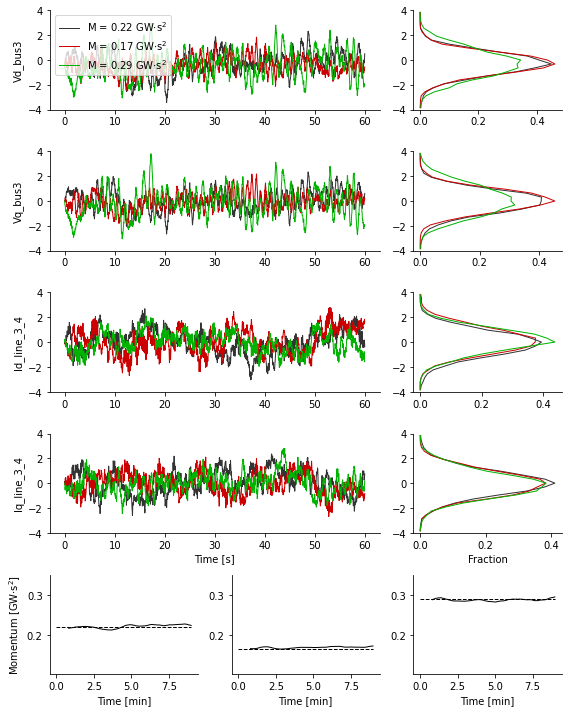

In [12]:
n_vars = len(var_names_fmt)
fig = plt.figure(figsize=(8, n_vars * 2.5))
if N_H < 3:
    gs = fig.add_gridspec(n_vars+1, 4)
elif N_H == 3:
    gs = fig.add_gridspec(n_vars+1, 6)
else:
    raise Exception('Supported values of N_H are 1, 2 or 3')
ax = []
for i in range(n_vars):
    if N_H < 3:
        ax.append([fig.add_subplot(gs[i, :3]), fig.add_subplot(gs[i, 3])])
    else:
        ax.append([fig.add_subplot(gs[i, :4]), fig.add_subplot(gs[i, 4:])])
if N_H < 3:
    ax.append([fig.add_subplot(gs[-1, :2]), fig.add_subplot(gs[-1, 2:])])
else:
    ax.append([fig.add_subplot(gs[-1, :2]), fig.add_subplot(gs[-1, 2:4]), fig.add_subplot(gs[-1, 4:])])

col = [[.2,.2,.2], [.8,0,0], [0,.7,0]]

bus_ID = rec_bus_IDs[0]
line_IDs = rec_bus_IDs[0], rec_bus_IDs[0] + 1

idx = t < 60

dm = np.max(measure_exact) - np.min(measure_exact)
ylim = [np.min(measure_exact) - dm / 2, np.max(measure_exact) + dm / 2]

for i in range(N_H):
    for j,var_name in enumerate(var_names_fmt):
        if 'bus' in var_name:
            key = var_name.format(bus_ID)
        elif 'line' in var_name:
            key = var_name.format(line_IDs[0], line_IDs[1])
        value = data_normalized[i][key]
        n,edges = np.histogram(value, bins=25, range=(-4,4), density=True)
        ax[j][0].plot(t[idx], value[idx], color=col[i], lw=1, \
                      label=f'{abbrv[area_measure]} = {measure_exact[i]:.2f} {measure_units}')
        ax[j][1].plot(n, edges[:-1] + np.diff(edges[:2])[0] / 2, color=col[i], lw=1)
        for a in ax[j]:
            a.set_ylim([-4,4])
        ax[j][0].set_ylabel(key)
    ax[-1][i].plot(time / 60, measure[i], 'k', lw=1)
    ax[-1][i].plot(time[[0,-1]] / 60, measure_exact[i] + np.zeros(2), 'k--', lw=1)
    ax[-1][i].set_ylim(ylim)
    ax[-1][i].set_xlabel('Time [min]')

for a in ax:
    for side in 'right','top':
        for aa in a:
            aa.spines[side].set_visible(False)

ax[0][0].legend(loc='best')
for i in range(1, N_H):
    ax[-1][0].get_shared_x_axes().join(ax[-1][0], ax[-1][i])

# ax[-1][0].set_xlim([0,30])
ax[-1][0].set_ylabel(f'{area_measure.capitalize()} [{measure_units}]')
ax[-2][0].set_xlabel('Time [s]')
ax[-2][1].set_xlabel('Fraction')
fig.tight_layout()
# output_filename = f'IEEE39_area{area_ID}_H_G1={H_G1}_' + \
#     f'rec_buses={rec_bus_list}_load_buses={stoch_load_bus_list}_const_H_{experiment_ID[:6]}.pdf'
# fig.savefig(output_filename)

## Step of measure with transient

In [ ]:
H_values = [
    OrderedDict([
        ('Pg30', H_G1), ('Pg31', 20), ('Pg32', 28), ('Pg33', 28.6), ('Pg34', 26),
        ('Pg35', 34.8), ('Pg36', 26.4), ('Pg37', 24.3), ('Pg38', 34.5), ('Pg39', 36)

    ]),
    OrderedDict([
        ('Pg30', H_G1), ('Pg31', 42), ('Pg32', 46), ('Pg33', 28.6), ('Pg34', 26),
        ('Pg35', 34.8), ('Pg36', 26.4), ('Pg37', 24.3), ('Pg38', 34.5), ('Pg39', 50)

    ])
]

measure_exact = []
for H_val in H_values:
    if area_measure == 'inertia':
        pass
    elif area_measure == 'energy':
        measure_exact.append(np.sum([H_val[gen_id] * P_nom[gen_id] for gen_id \
                                     in generators_areas_map['default'][area_ID - 1]]) * 1e-9)
    elif area_measure == 'momentum':
        measure_exact.append(2 * np.sum([H_val[gen_id] * P_nom[gen_id] for gen_id \
                                         in generators_areas_map['default'][area_ID - 1]]) * 1e-9 / 60)

data_file = data_dir + '/ieee39'
for gen_id in H_values[0]:
    data_file += '_' + '-'.join(map(lambda h: f'{h:.3f}', np.unique([H[gen_id] for H in H_values])))
data_file += '.h5'

t, _, data_normalized, data_sliding, _ = load_data_slide([data_file],
                                                         var_names,
                                                         data_mean,
                                                         data_std,
                                                         window_dur,
                                                         window_step,
                                                         add_omega_ref = False,
                                                         verbose = True)

dt = np.diff(t[:2])[0]
time, measure, _ = predict(model, data_sliding, window_step)

In [ ]:
fig = plt.figure(figsize = (6,9))
gs = fig.add_gridspec(2 * n_vars + 3 + 1, 1)
ax = []
for i in range(n_vars):
    ax.append(fig.add_subplot(gs[i*2:(i+1)*2]))
ax.append(fig.add_subplot(gs[-4:-1,0]))
ax.append(fig.add_subplot(gs[-1,0]))

ds = 5
for i,var_name in enumerate(var_names_fmt):
    for j,bus_id in enumerate(rec_bus_IDs[::-1]):
        ax[i].plot(t[::ds] / 60, data_normalized[var_name.format(bus_id)][::ds],
                   color=col[j], lw=1, label=f'bus{bus_id}')
    ax[i].set_ylim([-5,5])
    ax[i].set_ylabel(var_name.split('_')[0])

dm = np.max(measure_exact) - np.min(measure_exact)
ylim = [np.min(measure_exact) - dm / 3, np.max(measure_exact) + dm / 3]

ax[-2].plot(time[::ds] / 60, measure[::ds,0], color=col[0])
ax[-2].set_ylim(ylim)
ax[-2].plot([0, 30], measure_exact[0] + np.zeros(2), '--', color=col[0], lw=1)
ax[-2].plot([30, 60], measure_exact[1] + np.zeros(2), '--', color=col[0], lw=1)

ax[-1].plot([0, 30], measure_exact[0] + np.zeros(2), '-', color=col[0], lw=2)
ax[-1].plot([30, 60], measure_exact[1] + np.zeros(2), '-', color=col[0], lw=2)
ax[-1].plot(30 + np.zeros(2), ylim, '--', color=col[0], lw=1)
ax[-1].set_ylim(ylim)
# ax[-1].set_yticks(np.arange(8,15,2))
ax[-1].set_xlabel('Time [min]')

ax[0].legend(loc='lower right')

for a in ax:
    a.set_xlim([-1,61])
    for side in 'right', 'top':
        a.spines[side].set_visible(False)
    if a != ax[-1]:
        a.set_xticklabels([])

ax[-2].set_ylabel(f'{area_measure.capitalize()} [{measure_units}]')
ax[-1].set_ylabel(f'{abbrv[area_measure]} [{measure_units}]')

fig.tight_layout()
output_filename = f'IEEE39_area{area_ID}_H_G1={H_G1}_' + \
    f'rec_buses={rec_bus_list}_load_buses={stoch_load_bus_list}_step_H.pdf'
fig.savefig(output_filename)

## With a 4th generator (a compensator) added in area 1

In [ ]:
P_nom['Pg99'] = 100e6

H_99 = np.r_[5 : 41 : 2.5]

H_values = [
    default_H
]
for h in H_99:
    H_values.append(
        OrderedDict([
            ('Pg30', H_G1), ('Pg31', 30.3), ('Pg32', 35.8), ('Pg33', 28.6), ('Pg34', 26),
            ('Pg35', 34.8), ('Pg36', 26.4), ('Pg37', 24.3), ('Pg38', 34.5), ('Pg39', 42),
            ('Pg99', h)
        ])
    )
N_H = len(H_values)

data_normalized = []
measure = []
measure_exact = []
area_inertia = []
for H in H_values:
    if 'Pg99' in H:
        data_file = data_dir + '/ieee39_compensator_' + '_'.join(map(lambda h: f'{h:.3f}', H.values())) + '.h5'
        _,_,v,_ = read_area_values(data_file, generators_areas_map['compensator'], P_nom, area_measure)
        _,_,h,_ = read_area_values(data_file, generators_areas_map['compensator'], P_nom, 'inertia')
    else:
        data_file = data_dir + '/ieee39_' + '_'.join(map(lambda h: f'{h:.3f}', H.values())) + '.h5'
        _,_,v,_ = read_area_values(data_file, generators_areas_map['default'], P_nom, area_measure)
        _,_,h,_ = read_area_values(data_file, generators_areas_map['default'], P_nom, 'inertia')

    measure_exact.append(v[area_ID - 1])
    area_inertia.append(h[area_ID - 1])

    t, _, data_norm, data_sliding, _ = load_data_slide([data_file],
                                                        var_names,
                                                        None,
                                                        data_std,
                                                        window_dur,
                                                        window_step,
                                                        add_omega_ref = False,
                                                        verbose = True)
    data_normalized.append(data_norm)
    dt = np.diff(t[:2])[0]
    time, pred, _ = predict(model, data_sliding, window_step)
    measure.append(pred)
measure_exact = np.array(measure_exact)
area_inertia = np.array(area_inertia)

In [ ]:
n_vars = len(var_names_fmt)
fig = plt.figure(figsize=(9, n_vars * 3))
gs = fig.add_gridspec(n_vars+1, 4)
ax = []
for i in range(n_vars):
    ax.append([fig.add_subplot(gs[i, :3]), fig.add_subplot(gs[i, 3])])
ax.append([fig.add_subplot(gs[-1, :])])

col = [[.2,.2,.2], [.8,0,0], [0,.7,0], [0,0,.7]]
cmap = plt.get_cmap('gray', N_H+1)
bus_ID = rec_bus_IDs[0]

idx = t < 60

dm = np.max(measure_exact) - np.min(measure_exact)
ylim = [np.min(measure_exact) - dm / 2, np.max(measure_exact) + dm / 2]

for i in range(N_H):
    for j,var_name in enumerate(var_names_fmt):
        key = var_name.format(bus_ID)
        value = data_normalized[i][key]
        n,edges = np.histogram(value, bins=25, range=(-4,4), density=True)
        ax[j][0].plot(t[idx], value[idx], color=cmap(i), lw=1, \
                      label=f'{abbrv[area_measure]} = {measure_exact[i]:.2f} {measure_units}')
        ax[j][1].plot(n, edges[:-1] + np.diff(edges[:2])[0] / 2, color=cmap(i), lw=1)
        for a in ax[j]:
            a.set_ylim([-4,4])
        ax[j][0].set_ylabel(key)
    ax[-1][0].plot(time / 60, measure[i], color=cmap(i), lw=1)
    ax[-1][0].plot(time[[0,-1]] / 60, measure_exact[i] + np.zeros(2), '--', color=cmap(i), lw=1)
    ax[-1][0].set_ylim(ylim)
    ax[-1][0].set_xlabel('Time [min]')

for aa in ax:
    for side in 'right','top':
        for a in aa:
            a.spines[side].set_visible(False)
for i in range(n_vars):
    for j in range(2):
        ax[i][j].grid(axis='y', lw=0.5, linestyle=':')

# ax[0][0].legend(loc='best')
ax[-1][0].set_xlim([0,60])
ax[-1][0].set_ylim([0.35, 0.5])
ax[-1][0].set_ylabel(f'{area_measure.capitalize()} [{measure_units}]')
ax[-2][0].set_xlabel('Time [s]')
ax[-2][1].set_xlabel('Fraction')
fig.tight_layout()
output_filename = f'IEEE39_area{area_ID}_H_G1={H_G1}_' + \
    f'rec_buses={rec_bus_list}_load_buses={stoch_load_bus_list}_compensator_{experiment_ID[:6]}.pdf'
fig.savefig(output_filename)

In [ ]:
# mean absolute percentage error
mape = np.array([np.nanmean(np.abs((m - me) / me)) * 100 for m,me in zip(measure, measure_exact)])
# mean absolute error
mae = np.array([np.nanmean(np.abs(m - me)) for m,me in zip(measure, measure_exact)])
# increase in area momentum when the compensator is present
Dm = (measure_exact - measure_exact[0]) / measure_exact[0] * 100
# mean prediction
measure_predicted = np.array([np.nanmean(m) for m in measure])

In [ ]:
def make_axes(rows, cols, x_offset, y_offset, x_space, y_space, squeeze=True):
    w = (1 - np.sum(x_offset) - x_space * (cols - 1)) / cols
    h = (1 - np.sum(y_offset) - y_space * (rows - 1)) / rows
    
    ax = [[plt.axes([x_offset[0] + (w + x_space) * j,
                     y_offset[0] + (h + y_space) * i,
                     w, h]) for j in range(cols)] for i in range(rows-1, -1, -1)]
    
    for row in ax:
        for a in row:
            for side in 'right','top':
                a.spines[side].set_visible(False)

    if squeeze:
        if rows == 1 and cols == 1:
            return ax[0][0]
        if rows == 1:
            return ax[0]
        if cols == 1:
            return [a[0] for a in ax]
        
    return ax

fontsize = 8
lw = 0.75

matplotlib.rc('font', **{'family': 'Times New Roman', 'size': fontsize})
matplotlib.rc('axes', **{'linewidth': 0.75, 'labelsize': fontsize})
matplotlib.rc('xtick', **{'labelsize': fontsize})
matplotlib.rc('ytick', **{'labelsize': fontsize})

rows = 2
cols = 1
x_offset = [0.17, 0.03]
y_offset = [0.17, 0.075]
x_space = 0.1
y_space = 0.175

fig = plt.figure(figsize=(8/2.54, 6/2.54))
ax = make_axes(rows, cols, x_offset, y_offset, x_space, y_space)

ax[0].plot(measure_exact[[0,-1]], measure_exact[[0,-1]], 'k--', lw=1)
ax[0].plot(measure_exact[0], measure_predicted[0], 'ko', markerfacecolor='k', markersize=4, markeredgewidth=1)
ax[0].plot(measure_exact[1:], measure_predicted[1:], 'ko', markerfacecolor='w', markersize=4, markeredgewidth=1)
dx = measure_exact[-1] - measure_exact[0]
ax[0].set_xlim([measure_exact[0] - dx/20, measure_exact[-1] + dx/20])
ax[0].set_xlabel(f'{area_measure[0].capitalize()} [{measure_units}]')
ax[0].set_xticks(np.r_[0.36 : 0.50 : 0.03])
ax[0].set_ylim([measure_exact[0] - dx/10, measure_exact[-1] + dx/20])
ax[0].set_ylabel(f'Predicted {area_measure[0].capitalize()} [{measure_units}]')
ax[0].set_yticks(np.r_[0.36 : 0.50 : 0.03])

start = 7
x = Dm[start:] - Dm[start]
y = mape[start:] - mape[start]
power_law = lambda x,a,b: a * (x ** b)
popt,pcov = curve_fit(power_law, x, y, p0=[1,0.5])
x = np.linspace(x[0], x[-1], 50)
y = power_law(x, *popt) + mape[start]
x += Dm[start]
ax[1].plot(x, y, color=[.7,.7,.7], lw=2)
ax[1].plot(Dm[[1,6]], mape[1:7].mean() + np.zeros(2), color=[.4,.4,.4], lw=2)
ax[1].plot(Dm[0], mape[0], 'ko', markerfacecolor='k', markeredgewidth=1, markersize=4)
ax[1].plot(Dm[1:], mape[1:], 'ko', markerfacecolor='w', markeredgewidth=1, markersize=4)
dx = Dm[-1] - Dm[0]
ax[1].set_xlim([Dm[0] - dx/20, Dm[-1] + dx/20])
ax[1].set_ylim([0,13])
ax[1].set_yticks(np.r_[0:13:2])
ax[1].set_xlabel(f'{area_measure[0].capitalize()} increase [%]')
ax[1].set_ylabel('MAPE [%]')

for a in ax:
    for side in 'right','top':
        a.spines[side].set_visible(False)
    a.grid(which='major', axis='y', lw=0.5, color=[.6,.6,.6], ls=':')
    
output_filename = f'IEEE39_area{area_ID}_H_G1={H_G1}_' + \
    f'rec_buses={rec_bus_list}_load_buses={stoch_load_bus_list}_compensator_error_{experiment_ID[:6]}.pdf'
fig.savefig(output_filename)